## [Experiment] Sample notebook to see before and after prerproc

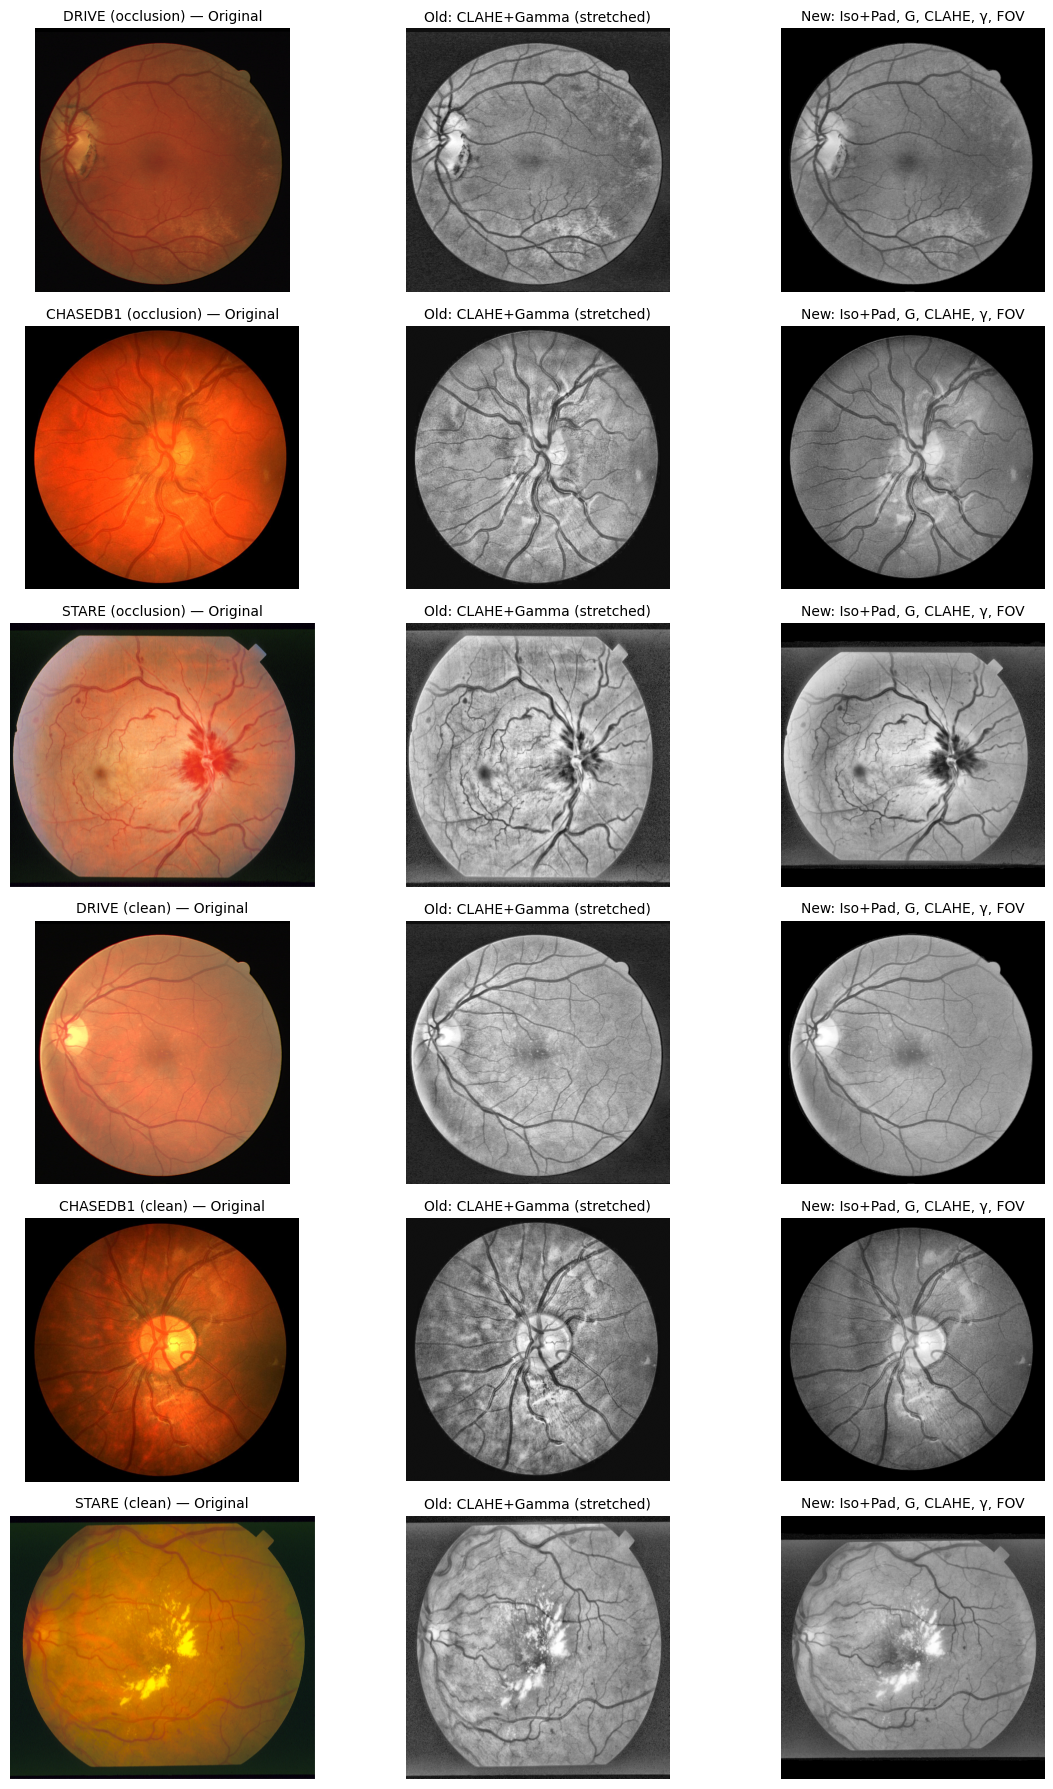

In [ ]:
%reload_ext autoreload
%autoreload 2

import sys, os
sys.path.append("../")  # so Python can see 'src' directory

import matplotlib.pyplot as plt
import cv2
import numpy as np

# OLD and NEW preprocessors
from src.data.preprocessing import preprocess_image_retina
from src.data.old_preprocessing import preprocess_image_clahe

# sample image paths
images = [
    ("DRIVE (occlusion)", "../data/raw/DRIVE/training/images/26_training.png"),
    ("CHASEDB1 (occlusion)", "../data/raw/CHASEDB1/training/images/Image_05L.jpg"),
    ("STARE (occlusion)", "../data/raw/STARE/training/images/image 0005.jpg"),
    ("DRIVE (clean)", "../data/raw/DRIVE/training/images/21_training.png"),
    ("CHASEDB1 (clean)", "../data/raw/CHASEDB1/training/images/Image_01L.jpg"),
    ("STARE (clean)", "../data/raw/STARE/training/images/image 0001.jpg"),
]

TARGET = 512  # target canvas size for the NEW pipeline

n = len(images)
plt.figure(figsize=(12, 3*n))

for idx, (label, image_path) in enumerate(images):
    if not os.path.exists(image_path):
        print(f"Missing: {image_path}")
        continue

    # load original RGB
    bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # OLD: weighted-gray + CLAHE + gamma (your current function; anisotropic resize)
    old = preprocess_image_clahe(image_path, resize=(TARGET, TARGET))  # (1,H,W) in [0,1]
    old_vis = old[0]

    # NEW: isotropic resize+pad, green channel, CLAHE (conservative), optional gamma, FOV masking
    new = preprocess_image_retina(
        image_path,
        target_size=TARGET,
        use_gamma=True,
        gamma=0.75,
        clahe_clip=3.5,
        clahe_tiles=4,
        apply_fov=True,
    )  # (1,H,W) in [0,1]
    new_vis = new[0]

    # --- display: Original | OLD | NEW ---
    r = idx + 1
    plt.subplot(n, 3, 3*(r-1) + 1)
    plt.imshow(rgb)
    plt.title(f"{label} — Original", fontsize=10)
    plt.axis("off")

    plt.subplot(n, 3, 3*(r-1) + 2)
    plt.imshow(old_vis, cmap="gray", vmin=0, vmax=1)
    plt.title("Old: CLAHE+Gamma (stretched)", fontsize=10)
    plt.axis("off")

    plt.subplot(n, 3, 3*(r-1) + 3)
    plt.imshow(new_vis, cmap="gray", vmin=0, vmax=1)
    plt.title("New: Iso+Pad, G, CLAHE, γ, FOV", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


Missing: ../data/raw/STARE/training/images/image 0006.jpg
Missing: ../data/raw/STARE/training/images/image 0007.jpg
Missing: ../data/raw/STARE/training/images/image 0008.jpg


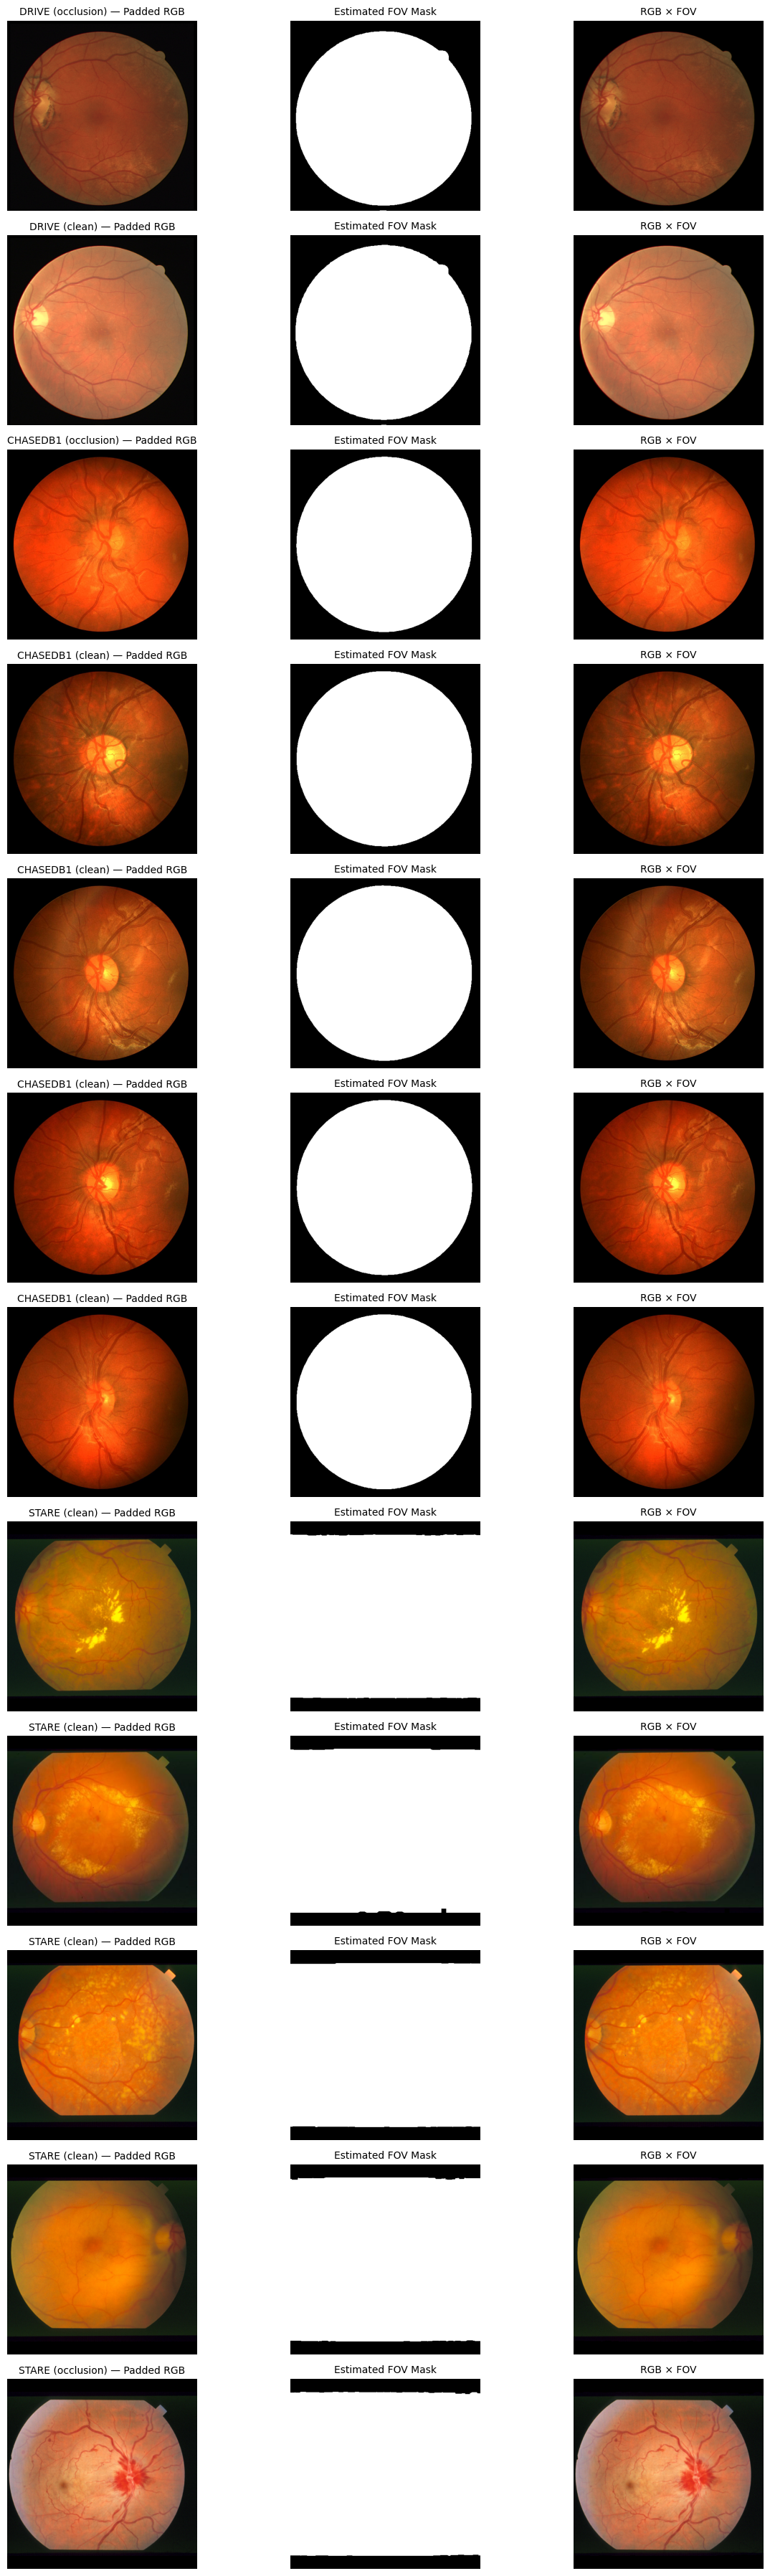

In [12]:
%reload_ext autoreload
%autoreload 2

import sys, os
sys.path.append("../")  # so Python can see 'src' directory

import matplotlib.pyplot as plt
import numpy as np
import cv2

# import FOV util + iso pad to match your preprocessing geometry
from src.data.preprocessing import _estimate_fov_mask, _iso_resize_and_pad

# sample image paths
images = [
    ("DRIVE (occlusion)", "../data/raw/DRIVE/training/images/26_training.png"),
    ("DRIVE (clean)", "../data/raw/DRIVE/training/images/21_training.png"),
    ("CHASEDB1 (occlusion)", "../data/raw/CHASEDB1/training/images/Image_05L.jpg"),
    ("CHASEDB1 (clean)", "../data/raw/CHASEDB1/training/images/Image_01L.jpg"),
    ("CHASEDB1 (clean)", "../data/raw/CHASEDB1/training/images/Image_02L.jpg"),
    ("CHASEDB1 (clean)", "../data/raw/CHASEDB1/training/images/Image_03L.jpg"),
    ("CHASEDB1 (clean)", "../data/raw/CHASEDB1/training/images/Image_04L.jpg"),
    ("STARE (clean)", "../data/raw/STARE/training/images/image 0001.jpg"),
    ("STARE (clean)", "../data/raw/STARE/training/images/image 0002.jpg"),
    ("STARE (clean)", "../data/raw/STARE/training/images/image 0003.jpg"),
    ("STARE (clean)", "../data/raw/STARE/training/images/image 0004.jpg"),
    ("STARE (occlusion)", "../data/raw/STARE/training/images/image 0005.jpg"),
    ("STARE (clean)", "../data/raw/STARE/training/images/image 0006.jpg"),
    ("STARE (clean)", "../data/raw/STARE/training/images/image 0007.jpg"),
    ("STARE (clean)", "../data/raw/STARE/training/images/image 0008.jpg"),
]

TARGET = 512  # keep consistent with your preprocessing

n = len(images)
plt.figure(figsize=(12, 3*n))

for idx, (label, image_path) in enumerate(images):
    if not os.path.exists(image_path):
        print(f"Missing: {image_path}")
        continue

    # load → RGB float32 in [0,1]
    bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    # match geometry used in preprocessing (isotropic resize + pad to square)
    rgb_pad = _iso_resize_and_pad(rgb, target=TARGET, pad_value=0.0)

    # estimate FOV mask on the padded RGB
    # detect which dataset this sample belongs to
    # if "STARE" in label:
    #     fov = _estimate_fov_mask(rgb_pad, dataset="STARE")
    # else:
    fov = _estimate_fov_mask(rgb_pad)  

    # apply mask for visualization
    masked_rgb = (rgb_pad * fov[..., None]).clip(0.0, 1.0)

    # --- display: Padded RGB | FOV Mask | Padded RGB × Mask ---
    r = idx + 1
    plt.subplot(n, 3, 3*(r-1) + 1)
    plt.imshow(rgb_pad)
    plt.title(f"{label} — Padded RGB", fontsize=10)
    plt.axis("off")

    plt.subplot(n, 3, 3*(r-1) + 2)
    plt.imshow(fov, cmap="gray", vmin=0, vmax=1)
    plt.title("Estimated FOV Mask", fontsize=10)
    plt.axis("off")

    plt.subplot(n, 3, 3*(r-1) + 3)
    plt.imshow(masked_rgb)
    plt.title("RGB × FOV", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
